# Week 3: A/B Testing I|
## AIM-5014-1A: Experimental Optimization
### David Sweet // 20230615

# Q1, 3 points

Redo last week's problem [2], but this time be "cavalier". Just run it until $se < PS/2$. Report your measurement and your decision (whether to accept to reject B).

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

_n_obs = 0
def observe(version: str):
    global _n_obs
    offset = 0.5*(_n_obs % 2)
    _n_obs += 1
    if version == "A":
        offset += 0.0
    elif version == "B":
        offset += 0.25
    else:
        assert False, f'version must be "A" or "B". Got {version}'
    return offset + 2*np.random.normal()

In [8]:
def design(practical_significance_level):
    # Estimate sigma_delta by pilot study
    y_a = []
    y_b = []
    for _ in range(100):
        if np.random.uniform() < .5: # randomize
            y_a.append(observe("A"))
        else:
            y_b.append(observe("B"))
    se_a_est = np.std(y_a) / np.sqrt(len(y_a))
    se_b_est = se_a_est  # reasonable approximation
    se_delta_est = np.sqrt(se_a_est**2 + se_b_est**2)
    
    num_observations = int(np.ceil( (2.5*se_delta_est / practical_significance_level)**2 ))
    return num_observations
def measure(num_observations):
    y_a = []
    y_b = []   
    
    while (
        len(y_a) < num_observations
        and len(y_b) < num_observations
    ):  # replicate
        if np.random.uniform() < .5: # randomize
            y_a.append(observe("A"))
        else:
            y_b.append(observe("B"))
    return np.array(y_a), np.array(y_b)    

# y_a, y_b = measure(n_obs)  
def analyze(y_a, y_b, practical_significance_level):
    delta_bar = y_b.mean() - y_a.mean()
    se_a = y_a.std() / np.sqrt(len(y_a))
    se_b = y_b.std() / np.sqrt(len(y_b))
    se_delta_bar = np.sqrt(se_a**2 + se_b**2)
    
    t = delta_bar / se_delta_bar

    s = f"t = {t:.2f}, delta_bar = {delta_bar:.2f}:   "
    # check practical significance and statistical significance
    if practical_significance_level/se_b < 2:
        s += "Accept B"
    else:
        s += "Reject B"
    return s

# analyze(y_a, y_b, n_obs)
practical_significance_level = .025
num_observations = design(practical_significance_level)
print (f"num_observations = {num_observations}")
analyze(*measure(num_observations), practical_significance_level)

num_observations = 1396


't = 4.59, delta_bar = 0.35:   Accept B'

# Q2, 3 points

In the course of a year, a team runs many A/B tests, one each week. It is the case that

- Most "B" versions do not outperform the extant system, A.
- Each experiment has P{False Positive} = 0.05 and P{False Negative} = 0.20

One experiment may be simulated with `run_experiment()` (below). The function `run_experiment()` takes the current expected business metric of the system, simulates an experiment and the decision to accept or reject B, then returns the new expected business metric of the system.

a) Plot the business metric of the system vs. week number for a year's worth of simulated experiments, starting out with `bm_a = 1`.  

b) Generate another plot with `p_fp=0.20`, a 20% chance of a false positives, and overlay it on the previous plot. Contrast the new plot with the plot from part (a).  


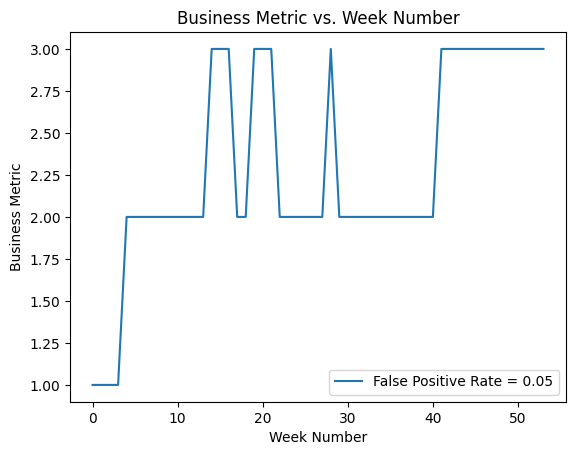

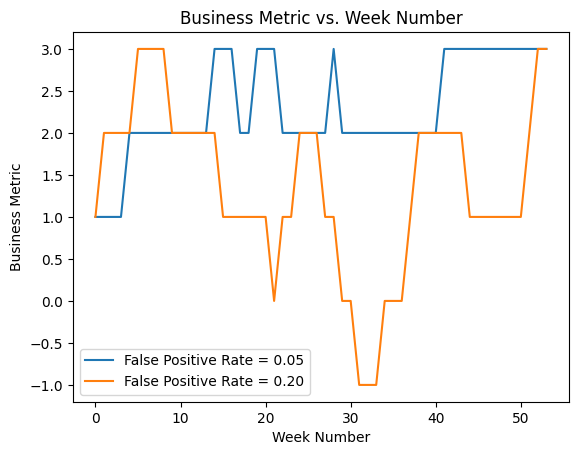

In [137]:
def run_experiment(bm_a, p_fp=0.05, p_fn=0.20):
    if np.random.uniform() < 1/5:
        # rarely, B is better than A
        bm_b = bm_a + 1
        if np.random.uniform() < p_fn:
            # There's a 20% change of a False Negative
            return bm_a
        else:
            return bm_b
    else:
        # usually, B is worse than A
        bm_b = bm_a - 1
        if np.random.uniform() < p_fp:
            # There's a 5% change of a False Positive
            return bm_b
        else:
            return bm_a     

def simulate_experiments(num_weeks, p_fp=0.05, p_fn=0.20):
    bm_a = 1  # Initial expected business metric of the system
    business_metrics = [bm_a]
    
    for week in range(1, num_weeks + 1):
        bm_a = run_experiment(bm_a, p_fp, p_fn)
        business_metrics.append(bm_a)
    
    return business_metrics

num_weeks = 53  # Number of weeks in a year
p_fp_a = 0.05  # False Positive rate for plot (a)
p_fp_b = 0.20  # False Positive rate for plot (b)

business_metrics_a = simulate_experiments(num_weeks, p_fp_a)
business_metrics_b = simulate_experiments(num_weeks, p_fp_b)

weeks = range(num_weeks + 1)

# Plot for (a)
plt.plot(weeks, business_metrics_a, label='False Positive Rate = 0.05')
plt.xlabel('Week Number')
plt.ylabel('Business Metric')
plt.title('Business Metric vs. Week Number')
plt.legend()
plt.show()

# Plot for (b) with overlay
plt.plot(weeks, business_metrics_a, label='False Positive Rate = 0.05')
plt.plot(weeks, business_metrics_b, label='False Positive Rate = 0.20')
plt.xlabel('Week Number')
plt.ylabel('Business Metric')
plt.title('Business Metric vs. Week Number')
plt.legend()
plt.show()


# Q3, 4 points

The function `measure_multiple_arms(num_arms)` effects a measurement of `num_arms` arms that all have the same expected business metric. The measurements are noisy, so it is possible to get false positives, where you conclude that one arm has a larger business metric than another.

(a) Write a function, `find_best(num_arms)`, that calls `measure_multiple_arms(num_arms)` then compares the arms, using a t test, in sequence like this:

- Compare arm 0 to arm 1, keeping the better of the two
- Compare the result of the previous step to arm 2, keeping the better of the two

and so on. In other words, implement a max-finding algorithm using a t test for pairwise comparison. Return the index to the arm that is best.

(b) Now write a function, `estimate_p_fp(num_arms)`, that calls `find_best(num_arms)` 10,000 times and uses the result to estimate the probability of a false positive, `p_fp`. Note that since all arms have the same expected business metrics, a false positive is any time `find_best(num_arms)` returns a non-zero value.

(c) As a check, `estimate_p_fp(2)` should return approximately 0.05 (the 5% false positive limit that we design for when we ask "Is t > 1.64?").

(d) Finally, plot your estimates of `p_fp` as a function of `num_arms` for `num_arms` in `range(2, 100, 10)`.

In [205]:
def measure_multiple_arms(num_arms):
    ys = []
    ses = []
#     arms = np.linspace(1, 100, 100)
    for i in range(num_arms):
        bm = 0
        ses.append(1) # make it easy; same se every time
        ys.append(bm + ses[-1]*np.random.normal())  # noisy measurement
    return np.array(ys), np.array(ses)

In [206]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

def find_best(num_arms, num_samples=2):
    ys = measure_multiple_arms(num_arms)[0]
#     print(ys)
    for i in range(1, num_samples):
        ys = np.vstack([ys, measure_multiple_arms(num_arms)[0]]) #Stacking the observations
    best_arm = ys[:, 0]
    for i in range(1, num_arms):
        _, p_value = ttest_ind(ys[:, i], best_arm)
#         print(p_value, i)
        if p_value < 0.05:  # Significance level of 0.05
            best_arm = ys[:, i]
    return best_arm

find_best(3, 10)

array([ 1.4181433 , -0.42114695, -0.64524129, -0.50871623, -1.53475905,
       -1.65441953,  0.10747124,  1.3328889 , -1.16510296,  0.1933444 ])

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [16:49<00:00, 100.91s/it]


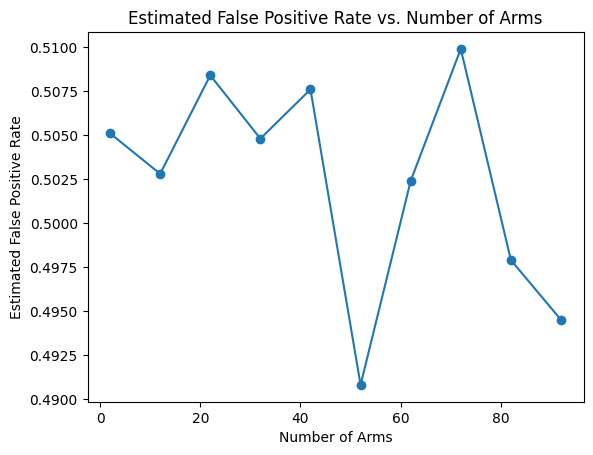

In [203]:
from tqdm import tqdm 
def estimate_p_fp(num_arms):
    num_false_positives = 0
    num_experiments = 10000
    for _ in range(num_experiments):
        best_arms = find_best(num_arms)
        if np.sum(best_arms) > 0:
            num_false_positives += 1
    p_fp = num_false_positives / num_experiments
    return p_fp

num_arms_range = range(2, 100, 10)
p_fp_estimates = []
for num_arms in tqdm(num_arms_range):
    p_fp_estimates.append(estimate_p_fp(num_arms))

plt.plot(num_arms_range, p_fp_estimates, marker='o')
plt.xlabel('Number of Arms')
plt.ylabel('Estimated False Positive Rate')
plt.title('Estimated False Positive Rate vs. Number of Arms')
plt.show()


# As we see that at 70 arms we get spike in the FP rate. We need more observations on Arms for analysis.